<a href="https://colab.research.google.com/github/lolddong/data_analysis/blob/main/16_CNN_FasionM-NIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-FasionMNIST 예제
- "Fashion-MNIST"는 가로 28px, 세로 28px 크기의 의류 이미지들을 저장하고 있는 데이터 셋으로 훈련데이터 6만건과 검증 데이터 1만건을 갖고 있다.
- URL: https://github.com/zalandoresearch/fashion-mnist
- 각 레이블 데이터의 의미:

|Label|Description|
|--|--|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

## 1. 패키지 가져오기

In [1]:
import helper

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.fashion_mnist import load_data

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## 2. 데이터셋 준비하기

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()
print(f'훈련 데이터 크기: {x_train.shape} / 레이블 크기: {y_train.shape}')
print(f'검증 데이터 크기: {x_test.shape} / 레이블 크기: {y_test.shape}')

4422102/4422102 [==============================] - 1s 0us/step
훈련 데이터 크기: (60000, 28, 28) / 레이블 크기: (60000,)
검증 데이터 크기: (10000, 28, 28) / 레이블 크기: (10000,)


## 3. 데이터 전처리
- 결측치 등의 데이터 이상점이 없는 예제이므로 생략

## 4. 탐색적 데이터 분석
### 1) 임의의 샘플값 확인

In [3]:
for i in x_train[1]:
  for j in i:
    print('%03d' % j, end='')
  print()

000000000000000001000000000000041188103054048043087168133016000000000000000000000000
000000000001000000000049136219216228236255255255255217215254231160045000000000000000
000000000000000014176222224212203198196200215204202201201201209218224164000000000000
000000000000000188219200198202198199199201196198198200200200200201200225041000000000
000000000000051219199203203212238248250245249246247252248235207203203222140000000000
000000000000116226206204207204101075047073048050045051063113222202206220224000000000
000000000000200222209203215200000070098000103059068071049000219206214210250038000000
000000000000247218212210215214000254243139255174251255205000215217214208220095000000
000000000045226214214215224205000042035060016017012013070000189216212206212156000000
000000000164235214211220216201052071089094083078070076092087206207222213219208000000
000000000106187223237248211198252250248245248252253250252239201212225215193113000000
00000000000000001705415922219320819219720020020020020120319521016

### 2) 종속변수 이름 정의

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt','Sneaker','Bag', 'Ankle boot']

### 3) 샘플에 대한 종속변수 확인

In [5]:
y = y_train[0]
yname = class_names[y]
print(y, " >> ", yname)

9  >>  Ankle boot


### 4) 데이터 그려보기

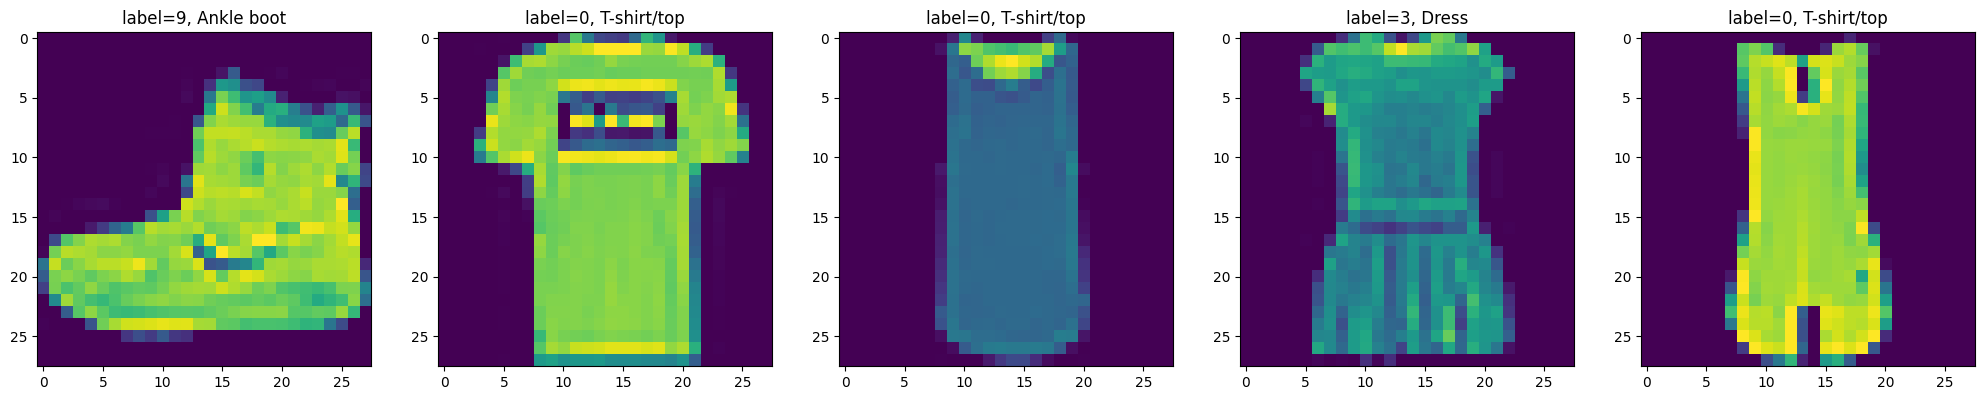

In [6]:
fig, ax = plt.subplots(1, 5, figsize = (25, 5), dpi = 100)
for i in range(0, len(ax)):
  train = x_train[i]
  label = y_train[i]
  ax[i].imshow(train)
  ax[i].set_title('label=%d, %s' % (label, class_names[label]))

## 5. 데이터 셋 분할하기
### 1) 랜덤시드 고정

In [7]:
np.random.seed(777)

### 2) 훈련데이터(독립변수)와 레이블(종속변수) 구분하기
- 처음부터 데이터셋이 구분되어 있었으므로 생략

### 3) 레이블에 대한 one-hot-encoding

In [8]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 6. 모델 개발
### 1) 훈련 데이터의 차수 확인

In [9]:
x_train.shape

(60000, 28, 28)

### 2) 훈련, 검증용 독립변수(이미지)의 차수 재설정
- 기본 CNN 골격에 맞게 28x28x1로 차원을 변경

In [10]:
x_train_reshape = x_train.reshape(x_train.shape[0],
                                  x_train.shape[1],
                                  x_train.shape[2],
                                  1)
x_test_reshape = x_test.reshape(x_test.shape[0],
                                  x_test.shape[1],
                                  x_test.shape[2],
                                  1)
print(f'훈련 데이터 {x_train_reshape.shape} /검증 데이터{x_test_reshape.shape}')

훈련 데이터 (60000, 28, 28, 1) /검증 데이터(10000, 28, 28, 1)


### 3) 모델 정의

In [11]:
my_model = Sequential()
my_model.add(Conv2D(filters=32,           # 필터/커널 개수 -> 클수록 모델이 더 정확해짐
                    kernel_size=(5, 5),   # 필터/커널 크기 => 작아질수록 모델이 더 정확해짐, 그러나 시간 더 소요
                    strides=(1, 1),       # 필터의 이동 간격
                    padding='same',       # same = input과 output이 같도록 패딩, valid = 패딩이 없음
                    activation='relu',
                    input_shape=(28, 28, 1))) # 첫 레이어에 input으로 들어오는 크기
my_model.add(BatchNormalization())        # 배치정규화
my_model.add(MaxPool2D(pool_size=(2, 2),  # 축소시킬 필터의 크기(비율)
                       strides = (2,2)))  # 필터의 이동 간격 (default = pool_size)
my_model.add(Dropout(0.25))               # 랜덤으로 25%의 뉴런을 쉬게함


my_model.add(Conv2D(filters = 64,
                    kernel_size = (3, 3),
                    strides=(1, 1),
                    padding='same',
                    activation = 'relu'))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D(pool_size=(2, 2),
                       strides=(2,2)))
my_model.add(Dropout(0.25))

my_model.add(Flatten())
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(10, activation='softmax'))

my_model.compile(optimizer = 'adam',
                 loss = 'categorical_crossentropy',
                 metrics=['acc'])

my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

### 4) 학습하기

In [12]:
start = dt.datetime.now()

result = my_model.fit(x_train_reshape,
                      y_train_one_hot,
                      epochs=500,
                      validation_data=(x_test_reshape, y_test_one_hot),
                      callbacks=[EarlyStopping(monitor='val_loss',
                                               patience = 5,
                                               verbose=1),
                                 ReduceLROnPlateau(monitor='val_loss',
                                                   patience=3,
                                                   factor=0.5,
                                                   min_lr=0.0001,
                                                   verbose=1)])


end = dt.datetime.now()

delta = end-start
'총 학습 소요시간: %d(초)' % delta.seconds

Epoch 1/500
1875/1875 [==============================] - 23s 5ms/step - loss: 0.4187 - acc: 0.8529 - val_loss: 0.3001 - val_acc: 0.8872 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2884 - acc: 0.8925 - val_loss: 0.3400 - val_acc: 0.8830 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2565 - acc: 0.9029 - val_loss: 0.2550 - val_acc: 0.9100 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2298 - acc: 0.9149 - val_loss: 0.2684 - val_acc: 0.9066 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2098 - acc: 0.9206 - val_loss: 0.2794 - val_acc: 0.9118 - lr: 0.0010
Epoch 6/500
1868/1875 [============================>.] - ETA: 0s - loss: 0.1955 - acc: 0.9276
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1958 - acc: 0.9275 - 

'총 학습 소요시간: 121(초)'

## 7. 학습 결과 평가

In [13]:
# 학습 결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.418659,0.852933,0.300091,0.8872,0.00100
2,0.288429,0.892483,0.339963,0.8830,0.00100
3,0.256513,0.902867,0.254968,0.9100,0.00100
4,0.229843,0.914883,0.268377,0.9066,0.00100
5,0.209757,0.920567,0.279360,0.9118,0.00100
6,0.195761,0.927533,0.265301,0.9075,0.00100
7,0.152408,0.941633,0.250516,0.9205,0.00050
8,0.138000,0.946467,0.251417,0.9228,0.00050
9,0.127824,0.951800,0.261286,0.9193,0.00050


In [14]:
# Colab 그래프 한글글꼴 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

from matplotlib import font_manager as fm
import matplotlib.pyplot as plt
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                  name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size':18, 'font.family':'NanumGothic'})

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,298 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120875 files and dire

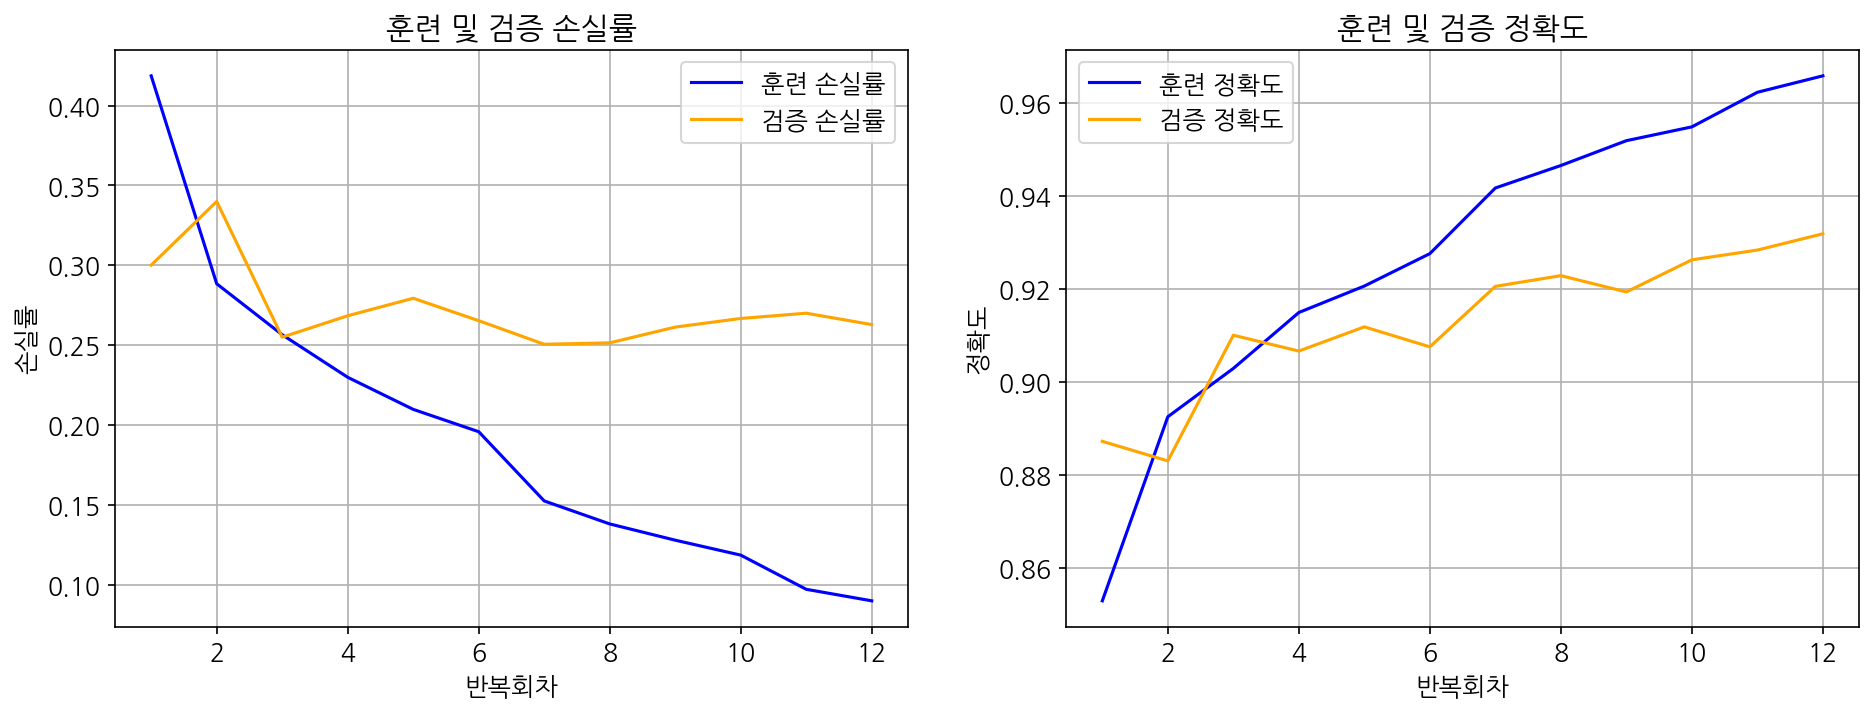

In [15]:
# 그래프 기본설정
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
sb.lineplot(x=result_df.index,
            y='loss',
            data=result_df,
            color='blue',
            label='훈련 손실률',
            ax=ax1)
sb.lineplot(x=result_df.index,
            y='val_loss',
            data=result_df,
            color='orange',
            label='검증 손실률',
            ax = ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
sb.lineplot(x=result_df.index,
            y='acc',
            data=result_df,
            color='blue',
            label='훈련 정확도',
            ax=ax2)
sb.lineplot(x=result_df.index,
            y='val_acc',
            data=result_df,
            color='orange',
            label='검증 정확도',
            ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [ ]:
evaluate1 = my_model.evaluate(x_train_reshape, y_train_one_hot)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))
evaluate2 = my_model.evaluate(x_test_reshape, y_test_one_hot)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

1875/1875 [==============================] - 39s 21ms/step - loss: 0.0277 - acc: 0.9903
최종 훈련 손실률: 0.027668, 최종 훈련 정확도: 0.990283
313/313 [==============================] - 7s 22ms/step - loss: 0.3221 - acc: 0.9302
최종 검증 손실률: 0.322103, 최종 검증 정확도: 0.930200


## 8. 학습 결과 적용
### 1) 훈련 데이터에 대한 예측 결과 산정

In [16]:
result = my_model.predict(x_train_reshape)
data_count, case_count = result.shape
print('%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다' % (data_count, case_count))
result[0]

1875/1875 [==============================] - 3s 2ms/step
60000개의 훈련 데이터가 10개의 경우의 수를 갖는다


array([1.2874817e-13, 2.7708825e-13, 1.0939566e-16, 1.6706927e-12,
       1.2566705e-15, 2.3433365e-11, 4.2322975e-15, 4.0948089e-06,
       6.9486403e-13, 9.9999595e-01], dtype=float32)

### 2) 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [17]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([9, 0, 0, ..., 3, 0, 5])

### 3) 데이터 비교

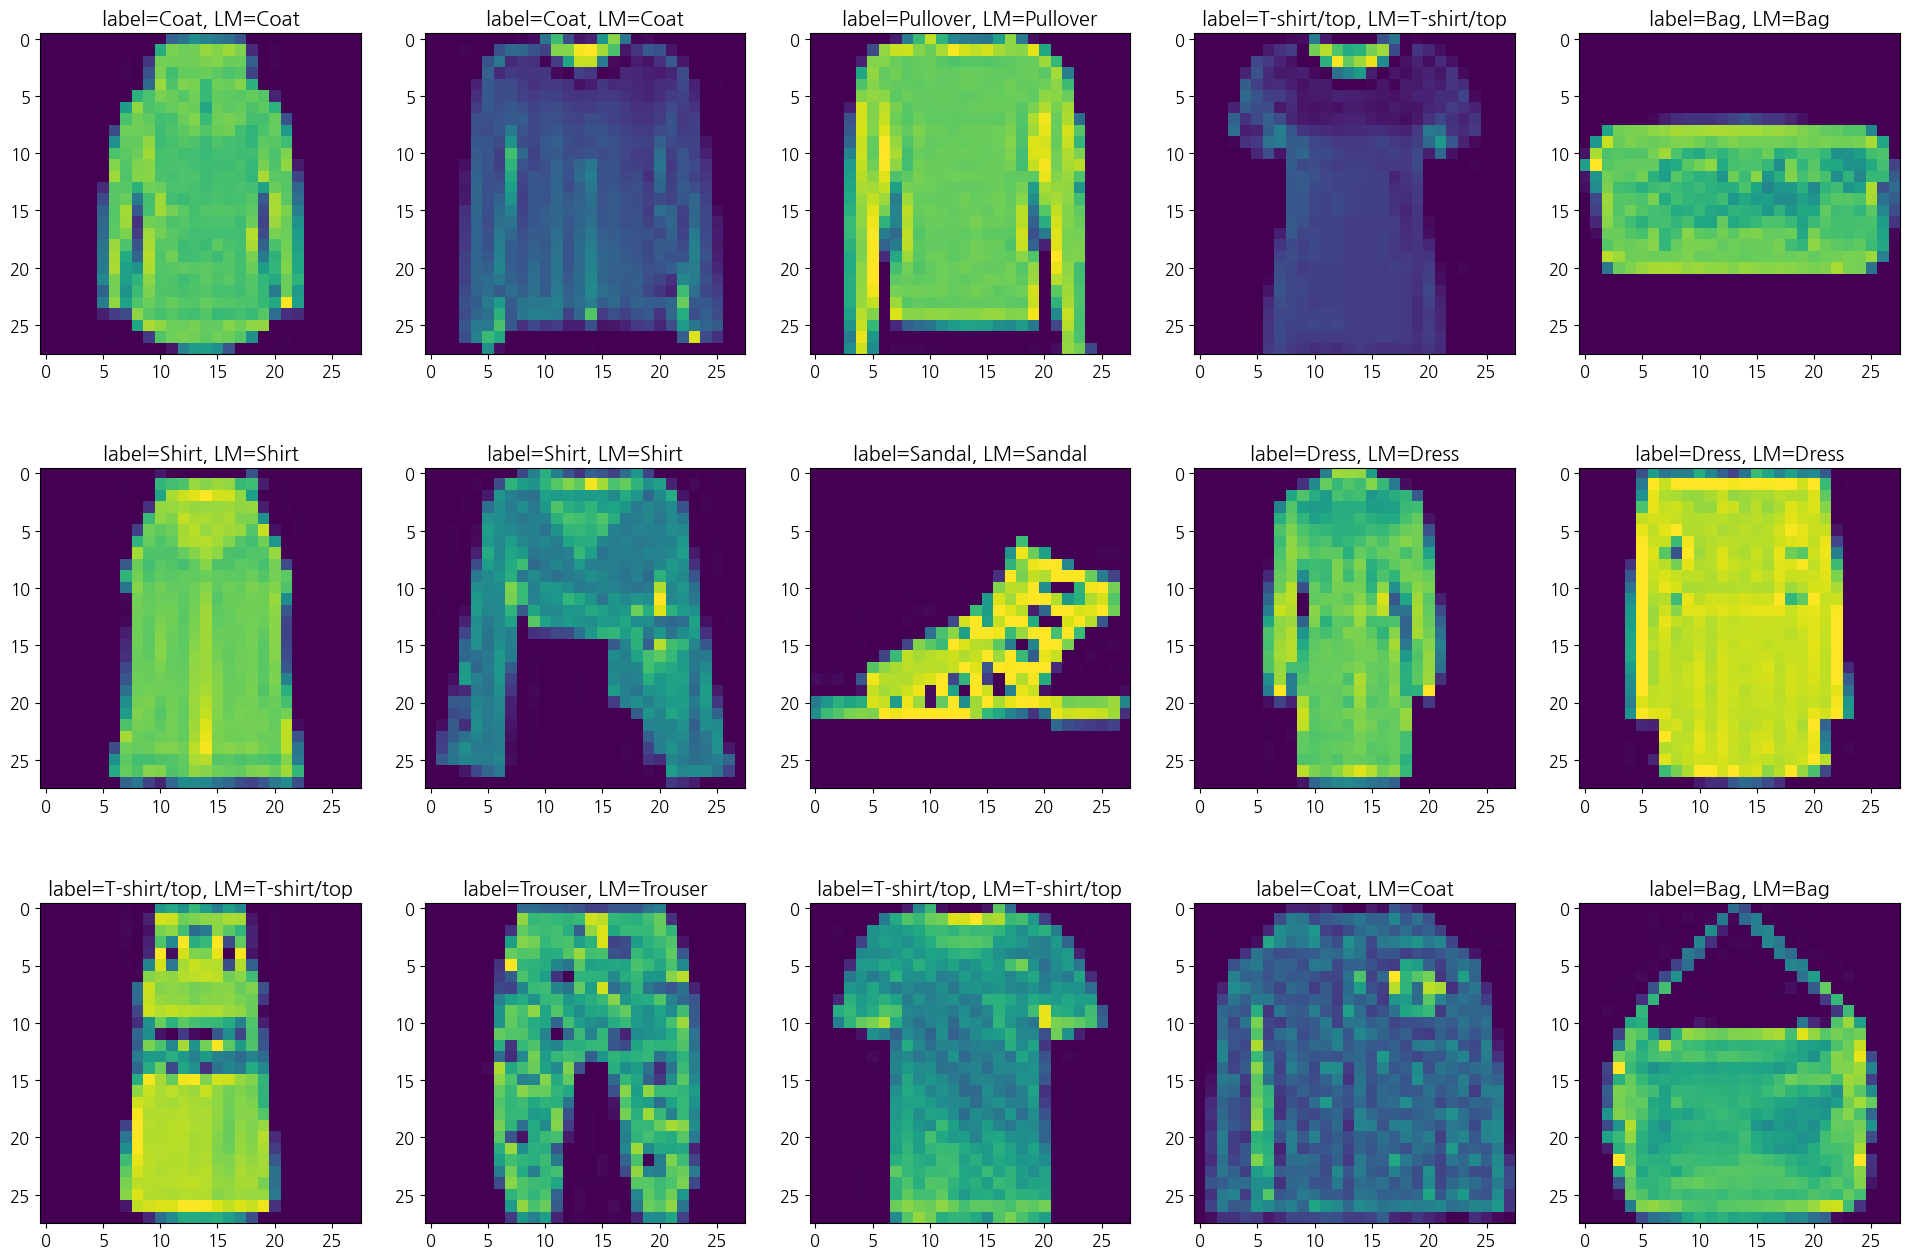

In [18]:
row = 3
col = 5
fig, ax = plt.subplots(row,
                       col,
                       figsize = ((col+1)*4, (row+1)*4),
                       dpi=100)

size = row*col
length = len(y_train)

for i in range(0, size):
  k = np.random.randint(length)
  train = x_train[k]
  label = y_train[k]
  ax[i//col][i%col].imshow(train)
  # ax[i//col][i%col].set_title("label=%d, LM=%d" % (label, arg_result[k]))
  ax[i//col][i%col].set_title('label=%s, LM=%s' % (class_names[label],
                                                   class_names[arg_result[k]]))
plt.show()
plt.close()

### 4) 혼돈 행렬

In [19]:
cm = confusion_matrix(y_train, arg_result)
cmdf2 = DataFrame(cm,
                  columns=list(map(lambda x: '(r)%s' % class_names[x],
                                   range (10))),
                          index = list(map(lambda x: '(p)%s' % class_names[x],
                                           range(10))))
cmdf2


,(r)T-shirt/top,(r)Trouser,(r)Pullover,(r)Dress,(r)Coat,(r)Sandal,(r)Shirt,(r)Sneaker,(r)Bag,(r)Ankle boot
(p)T-shirt/top,5770,0,12,11,1,0,205,0,1,0
(p)Trouser,0,6000,0,0,0,0,0,0,0,0
(p)Pullover,19,0,5612,10,213,0,146,0,0,0
(p)Dress,4,1,2,5923,58,0,12,0,0,0
(p)Coat,2,0,62,16,5742,0,178,0,0,0
(p)Sandal,0,0,0,0,0,5998,0,2,0,0
(p)Shirt,134,0,60,20,52,0,5734,0,0,0
(p)Sneaker,0,0,0,0,0,0,0,5975,0,25
(p)Bag,0,0,0,0,0,0,0,0,6000,0
(p)Ankle boot,0,0,0,0,0,0,0,33,0,5967


### 5) 혼돈행렬 히트맵

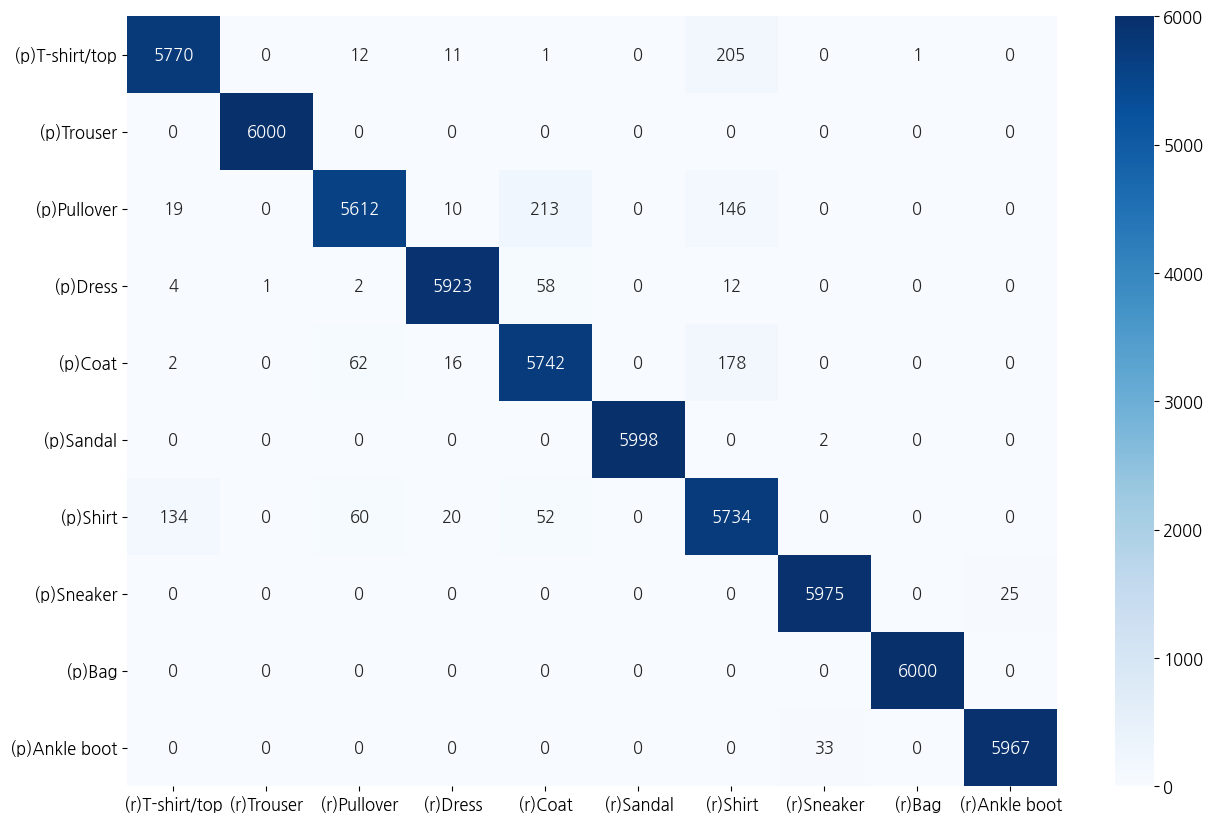

In [20]:
plt.figure(figsize = (15, 10))
sb.heatmap(cmdf2, annot=True, fmt='d', cmap='Blues')
plt.show()
plt.close()

## 9. 임의의 이미지 판별하기
### 1) 이미지 불러오기

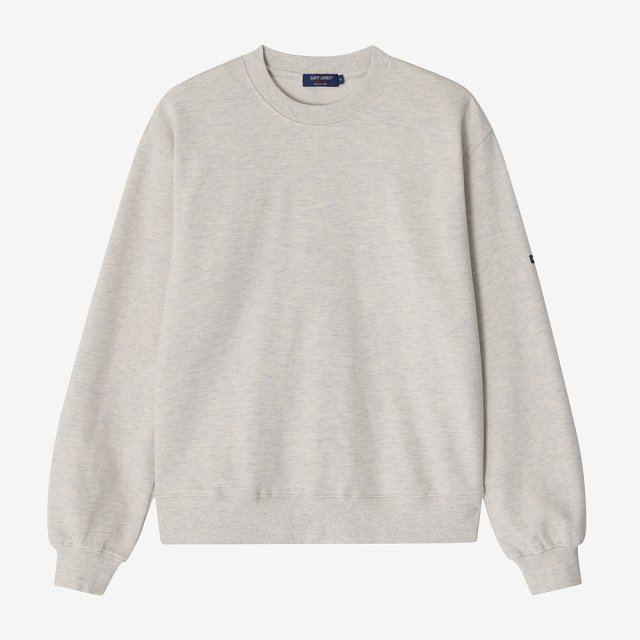

In [22]:
sample = Image.open('image32_sample.png')
sample

### 2) 흑백 이미지로 변환
- 컬러 이미지는 (28x28x3)의 shape를 갖는다.
- 학습 모델은 흑백이미지를 통해 (28x28x1)의 shape를 갖는 데이터로 학습되었으므로 이에 맞게 변환이 필요하다

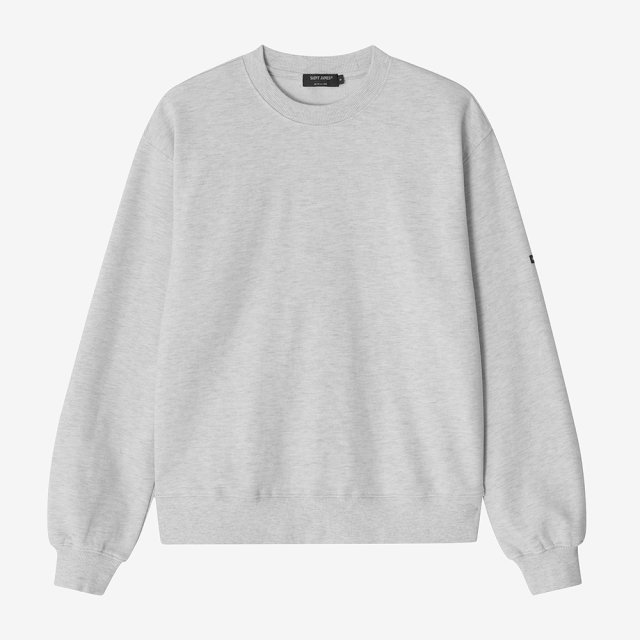

In [23]:
gray = sample.convert('L')
gray

### 3) 이미지 크기 축소
- 훈련모델이 학습한 이미지의 크기는 28x28이므로 이에 맞게 리사이즈가 필요하다

In [24]:
resample = gray.resize([28,28])
resample

### 4) 이미지를 배욜로 변환

In [25]:
img_array = np.array(resample)
img_array.shape

(28, 28)

### 5) 배열로 변환된 이미지 확인

In [26]:
for i in img_array:
  for j in i:
    print('%03d' % j, end='')
  print()

245245245245245245245245245245245245245245245245245245245245245245245245245245245245
245245245245245245245245245246247243246247247246244247246245245245245245245245245245
245245245245245245245246246237221196211218217210205225239247246245245245245245245245
245245245245245245246238216202198191189143127190198199201212237246245245245245245245
245245245245245246241208198201199201193190195199200202202195193241246245245245245245
245245245245245247224198198202201201202201200202203203204201178215247245245245245245
245245245245245242210201200202201201202203203204205204206204173198243245245245245245
245245245245247231204207203201202200202203202204205203204206170194234246245245245245
245245245245247216203208203202202198202204202204208205204207169193220247245245245245
245245245245244203204207202203200199203205202203209208204207168194207244245245245245
245245245246236196206209203204196199204204201202208211203207170194200235246245245245
24524524524722419320720820520319320220520520020020721220520817319

### 6) 배경 제거
- 데이터의 명확한 구분을 위해 배경으로 적용되어있는 `245` 색상을 `0`으로 강제 조절

In [27]:
img_array_trans = np.where(img_array == 245, 0, img_array)

for i in img_array_trans:
  for j in i:
    print('%03d' % j, end = '')
  print()

000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000246247243246247247246244247246000000000000000000000000000
000000000000000000000246246237221196211218217210205225239247246000000000000000000000
000000000000000000246238216202198191189143127190198199201212237246000000000000000000
000000000000000246241208198201199201193190195199200202202195193241246000000000000000
000000000000000247224198198202201201202201200202203203204201178215247000000000000000
000000000000000242210201200202201201202203203204205204206204173198243000000000000000
000000000000247231204207203201202200202203202204205203204206170194234246000000000000
000000000000247216203208203202202198202204202204208205204207169193220247000000000000
000000000000244203204207202203200199203205202203209208204207168194207244000000000000
000000000246236196206209203204196199204204201202208211203207170194200235246000000000
00000000024722419320720820520319320220520520020020721220520817319

### 7) 차수 재설정

In [28]:
img_array_trans.shape

(28, 28)

In [29]:
img_array_reshape = img_array_trans.reshape(1,
                                            img_array_trans.shape[0],
                                            img_array_trans.shape[1],
                                            1)
img_array_reshape.shape

(1, 28, 28, 1)

### 8) 준비한 데이터를 학습 모델에 적용

In [30]:
result = my_model.predict(img_array_reshape)
data_count, case_count = result.shape
print("%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

1/1 [==============================] - 0s 140ms/step
1개의 훈련 데이터가 10개의 경우의 수를 갖는다.


array([4.7353897e-04, 2.1317082e-11, 1.2765487e-01, 2.4224203e-08,
       7.7413708e-01, 1.4415900e-09, 9.7734571e-02, 1.3644357e-12,
       3.9556411e-08, 5.7965518e-11], dtype=float32)

### 9) 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [31]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([4])

### 10) 데이터 비교

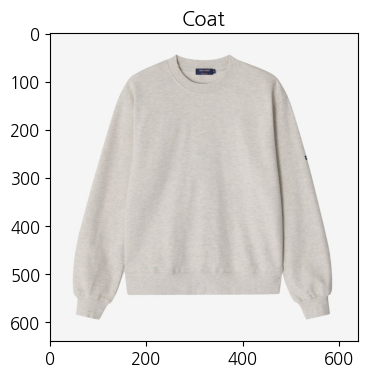

In [32]:
plt.figure(figsize=(4,4))
plt.imshow(sample)
plt.title(class_names[arg_result[0]])
plt.show()
plt.close()